In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import sys

In [4]:
sys.path.insert(0, "../../src/main/")

In [25]:
import pandas as pd 
import numpy as np
import config, utils
import os
import sys
import data
import time
from tqdm import tqdm_notebook as tqdm
import keras

In [6]:
datafiles=!ls ../input/nni/traintest_submols_feat_part_*.pklz
datafiles

['../input/nni/traintest_submols_feat_part_00.pklz',
 '../input/nni/traintest_submols_feat_part_0.pklz']

In [7]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, datafiles, data_size, data_mean, batch_size=32,   shuffle=True, model_type=0):
        'Initialization'
        self.datafiles=list(datafiles)
        self.curr_file_idx=-1
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data_size=data_size
        self.data_mean=np.reshape(data_mean,[1,1,-1]).astype(np.float32)
        self.model_type=model_type #0 autoencoder, 1 prediction, 2 both
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor((self.data_size) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'

        # Generate data
        X = self.__data_generation_next_batch()-self.data_mean
        if self.model_type==0:
            return X,X
        elif self.model_type==1:
            return X,X[:,1:,:]
        elif self.model_type==2:
            return X,[X,X[:,1:,:]]
        

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.datafiles)
        self.current_datafile=self.datafiles[0]
        self.curr_file_idx=-1
        self.__on_read_next_file()
        
    def __on_read_next_file(self):
        if  self.curr_file_idx < len(self.datafiles):
            self.curr_file_idx+=1
        else:
            self.curr_file_idx=0
        
        filename=self.datafiles[self.curr_file_idx]
        print(" reading "+filename)
        self.data =utils.load_zipped_pickle(filename)['value']
        n=len(self.data)
        print("# records: " + str(n))
        self.indexes_in_file = list(range(n))
        if self.shuffle:
            np.random.shuffle(self.indexes_in_file)
        self.curr_idx_in_file =0
        
    def __data_generation_next_instance(self):
        if self.curr_idx_in_file < len(self.data):
            pass 
        else:
            self.__on_read_next_file()

        i= self.indexes_in_file[self.curr_idx_in_file]
        b=self.data[i]
        self.curr_idx_in_file+=1
        
        return utils.uncompress_np_array(b)
    
    def __data_generation_next_batch(self):
        X=[]
        while len(X)<self.batch_size:
            X.append(self.__data_generation_next_instance())
        
        return np.array(X, dtype=np.float32)


In [26]:
class DataGeneratorPar(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, datafiles, data_size, data_mean, batch_size=32, model_type=0):
        'Initialization'
        self.datafiles=list(datafiles)
        self.batch_size = batch_size
        self.data_size=data_size
        self.data_mean=np.reshape(data_mean,[1,1,-1]).astype(np.float32)
        self.model_type=model_type #0 autoencoder, 1 prediction, 2 both
        
        self.current_datafile=None
        self.data=None

        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor((self.data_size) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'

        # Generate data
        X = self.__data_generation_next_batch()-self.data_mean
        if self.model_type==0:
            return X,X
        elif self.model_type==1:
            return X,X[:,1:,:]
        elif self.model_type==2:
            return X,[X,X[:,1:,:]]
        

    def on_epoch_end(self):
        'Updates indexes after each epoch'

        pass
        self.current_datafile=None
        self.data=None
    
    
    def __set_seed(self):
        i = int(time.time()) + os.getpid()
        np.random.seed(i)
        
    def __on_read_next_file(self):
        self.__set_seed()
        np.random.shuffle(self.datafiles)
        print(self.datafiles)
        
        self.current_datafile=self.datafiles[0]
        self.curr_file_idx=np.random.permutation(range(len(self.datafiles)))[0]
        
        filename=self.current_datafile
        print(" reading "+filename)
        self.data =utils.load_zipped_pickle(filename)['value']
        n=len(self.data)
        print("# records: " + str(n))
        self.indexes_in_file = list(range(n))
        np.random.shuffle(self.indexes_in_file)
        self.curr_idx_in_file =0
        
    def __data_generation_next_instance(self):
        if self.curr_idx_in_file < len(self.data):
            pass 
        else:
            self.data = None 
            self.__on_read_next_file()

        i= self.indexes_in_file[self.curr_idx_in_file]
        b=self.data[i]
        self.curr_idx_in_file+=1
        
        return utils.uncompress_np_array(b)
    
    def __data_generation_next_batch(self):
        if self.data is None:
            self.__on_read_next_file()
        X=[]
        while len(X)<self.batch_size:
            X.append(self.__data_generation_next_instance())
        
        return np.array(X, dtype=np.float32)


In [9]:
%time gen = DataGenerator(datafiles,data_size=10000, data_mean=np.zeros(3213))

 reading ../input/nni/traintest_submols_feat_part_00.pklz
# records: 716364
CPU times: user 14 s, sys: 984 ms, total: 14.9 s
Wall time: 14.9 s


In [10]:
for i in tqdm(range(len(gen))):
    a=gen[i]

In [45]:
%time gen = DataGeneratorPar(datafiles,data_size=10000, data_mean=np.zeros(3213))

CPU times: user 176 ms, sys: 4 ms, total: 180 ms
Wall time: 176 ms


In [46]:
for i in tqdm(range(len(gen))):
    a=gen[i]

 reading ../input/nni/traintest_submols_feat_part_00.pklz
# records: 716364



In [13]:
import gc
gc.collect()

0

In [9]:
from keras.models import Sequential, Model
from keras.layers import LSTM, Bidirectional
from keras.layers import Dense, Input, Lambda
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model

In [10]:
def make_model(model_type, hidden_units=128, activation='relu',input_shape=[30,3213], bidirectional=False, return_hidden_model=False):
    if model_type==0:
        return make_model_0(hidden_units,activation,input_shape,bidirectional,return_hidden_model)
    elif model_type==1:
        return make_model_1(hidden_units,activation,input_shape,bidirectional,return_hidden_model)
    elif model_type==2:
        return make_model_2(hidden_units,activation,input_shape,bidirectional,return_hidden_model)

def make_model_0(hidden_units=128, activation='relu',input_shape=[30,3213], bidirectional=False, return_hidden_model=False):
    if False:
        pass
    else:
        input_sequences = Input(shape=input_shape, name="main_input")
        x=input_sequences
        lstm_layer=LSTM(hidden_units, activation=activation)
        if(bidirectional):
            x=Bidirectional(lstm_layer)(x)
        else:
            x=lstm_layer(x)
        x=Lambda(lambda u:u, name='repr_hidden')(x)
        
        x=RepeatVector(input_shape[0])(x)
        x=LSTM(hidden_units, activation=activation, return_sequences=True)(x)
        x=TimeDistributed(Dense(input_shape[-1]))(x)
        model = Model(inputs=[input_sequences], outputs=[x])
        return model
    
def make_model_1(hidden_units=128, activation='relu',input_shape=[30,3213], bidirectional=False, return_hidden_model=False):
    if False:
        pass
    else:
        input_sequences = Input(shape=input_shape, name="main_input")
        x=input_sequences
        lstm_layer=LSTM(hidden_units, activation=activation)
        if(bidirectional):
            x=Bidirectional(lstm_layer)(x)
        else:
            x=lstm_layer(x)
        x=Lambda(lambda u:u, name='repr_hidden')(x)
            
        x=RepeatVector(input_shape[0]-1)(x)
        x=LSTM(hidden_units, activation=activation, return_sequences=True)(x)
        x=TimeDistributed(Dense(input_shape[-1]))(x)
        model = Model(inputs=[input_sequences], outputs=[x])
        return model

def make_model_2(hidden_units=128, activation='relu',input_shape=[30,3213], bidirectional=False, return_hidden_model=False):
    if False:
        pass
    else:
        input_sequences = Input(shape=input_shape, name="main_input")
        x=input_sequences
        lstm_layer=LSTM(hidden_units, activation=activation)
        if(bidirectional):
            x=Bidirectional(lstm_layer)(x)
        else:
            x=lstm_layer(x)
        x=Lambda(lambda u:u, name='repr_hidden')(x)
        
        x1=RepeatVector(input_shape[0])(x)
        x1=LSTM(hidden_units, activation=activation, return_sequences=True)(x1)
        x1=TimeDistributed(Dense(input_shape[-1]))(x1)
        
        x2=RepeatVector(input_shape[0]-1)(x)
        x2=LSTM(hidden_units, activation=activation, return_sequences=True)(x2)
        x2=TimeDistributed(Dense(input_shape[-1]))(x2)
        model = Model(inputs=[input_sequences], outputs=[x1,x2])
        return model    

In [11]:
# model.fit_generator(generator=training_generator,
#                     validation_data=validation_generator,
#                     use_multiprocessing=True,
#                     workers=6)

In [27]:
%time gen = DataGeneratorPar(datafiles,data_size=100, batch_size=4, data_mean=np.zeros(3213), model_type=2)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 324 µs


In [13]:
model=make_model(2,hidden_units=16,bidirectional=True)

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
model.compile(optimizer='adam', loss='mse')    

In [29]:
%%time
model.fit_generator(generator=gen,epochs=3,use_multiprocessing=True,
                     workers=2)

Epoch 1/3
Epoch 1/3
['../input/nni/traintest_submols_feat_part_0.pklz', '../input/nni/traintest_submols_feat_part_00.pklz']
['../input/nni/traintest_submols_feat_part_0.pklz', '../input/nni/traintest_submols_feat_part_00.pklz']
 reading ../input/nni/traintest_submols_feat_part_0.pklz
 reading ../input/nni/traintest_submols_feat_part_0.pklz
# records: 716364
# records: 716364
25/25 [==============================] - 17s 678ms/step - loss: 8167.2408 - time_distributed_1_loss: 4015.2465 - time_distributed_2_loss: 4151.9943
Epoch 2/3
['../input/nni/traintest_submols_feat_part_0.pklz', '../input/nni/traintest_submols_feat_part_00.pklz']
 reading ../input/nni/traintest_submols_feat_part_0.pklz
['../input/nni/traintest_submols_feat_part_00.pklz', '../input/nni/traintest_submols_feat_part_0.pklz']
 reading ../input/nni/traintest_submols_feat_part_00.pklz
# records: 716364
# records: 716364
25/25 [==============================] - 17s 683ms/step - loss: 5109.1547 - time_distributed_1_loss: 2515

In [33]:
hidden_model = Model(inputs=model.inputs, outputs=model.get_layer("repr_hidden").output)


In [39]:
hidden_model.predict(a[0]).shape

(4, 32)

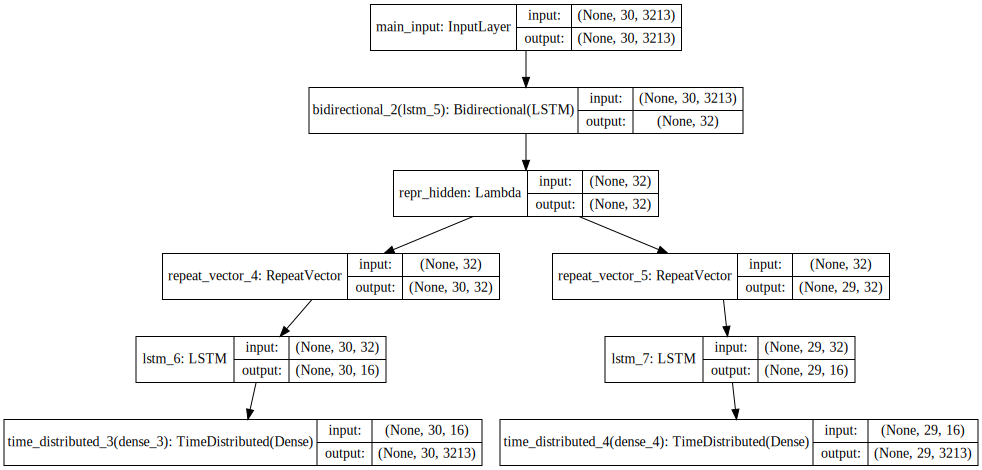

In [30]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

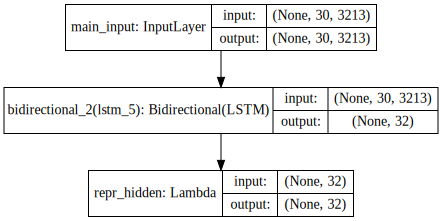

In [34]:
SVG(model_to_dot(hidden_model, show_shapes=True).create(prog='dot', format='svg'))